## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import numpy as np

In [4]:
import scanpy as sc

In [5]:
import harmonypy as hm
import pyliger

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [6]:
import scib

## Load data and view the data without integration

In [8]:
adata = sc.read_h5ad('../examples/data/demo1_sp_adata.h5ad')

chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']

adata = adata[adata.obs['donor_slice'].isin(chosen_slices), :]

In [9]:
sc.tl.pca(adata)

In [10]:
sc.pp.neighbors(adata)

In [11]:
sc.tl.umap(adata)

In [12]:
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)

## Harmony integration

In [13]:
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs[['donor_slice']], ['donor_slice'])

2023-10-02 16:21:08,819 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2023-10-02 16:21:13,601 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2023-10-02 16:21:13,675 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2023-10-02 16:21:16,213 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2023-10-02 16:21:18,716 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2023-10-02 16:21:20,801 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2023-10-02 16:21:22,995 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2023-10-02 16:21:23,949 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2023-10-02 16:21:24,906 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2023-10-02 16:21:25,865 - 

In [14]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
adata.obsm['X_harmony'] = res.to_numpy().T

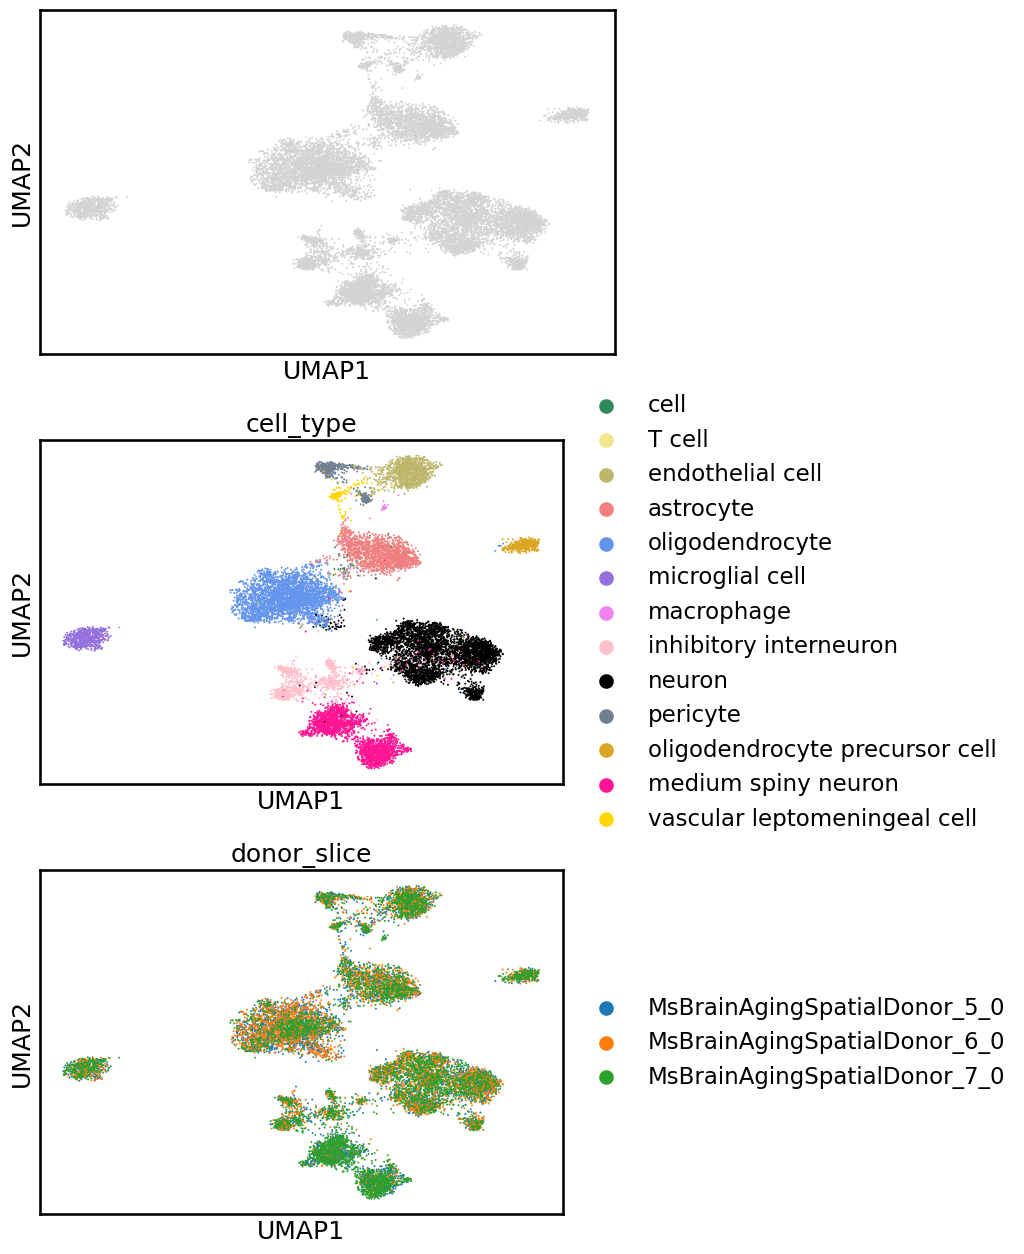

In [37]:
sc.pp.neighbors(adata, use_rep='X_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)

## Liger

In [16]:
adatas = []
for i in chosen_slices:
    adatas.append(adata.raw.to_adata()[adata.obs['donor_slice'] == i, :])
    adatas[-1].obs.index.name = 'cell_names'
    adatas[-1].var.index.name = 'gene_names'
    adatas[-1].uns['sample_name'] = i
liger = pyliger.create_liger(adatas)

In [17]:
pyliger.normalize(liger)
pyliger.select_genes(liger)
pyliger.scale_not_center(liger)
pyliger.optimize_ALS(liger, k = 20)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:32<00:00,  1.09s/it]


In [18]:
pyliger.quantile_norm(liger)

In [19]:
adata.obsm['X_liger'] = np.vstack([adata.obsm["H_norm"] for adata in liger.adata_list])

In [20]:
sc.pp.neighbors(adata, use_rep='X_liger', metric='cosine')
sc.tl.umap(adata)

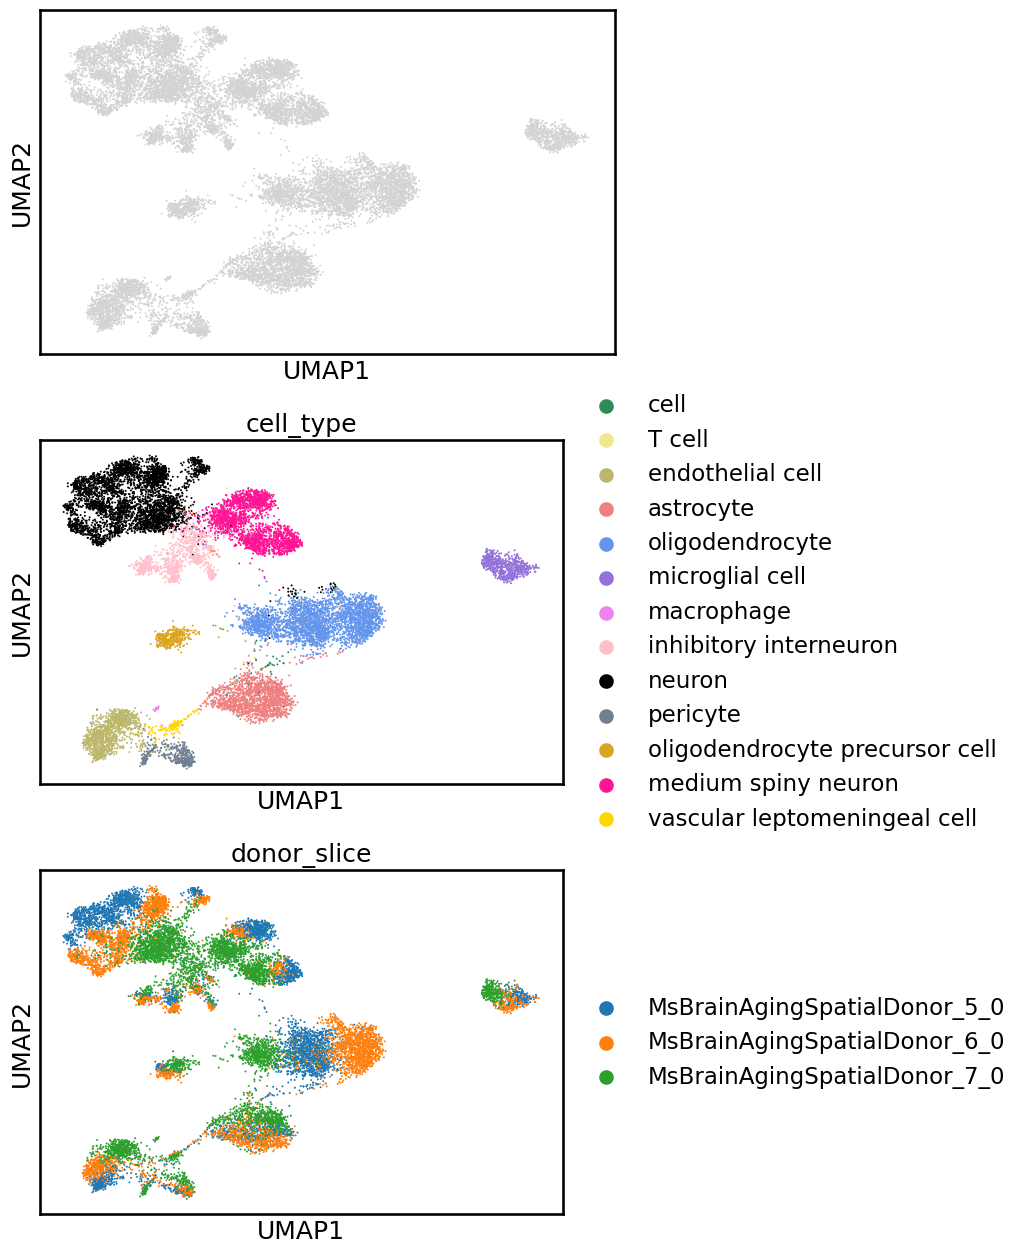

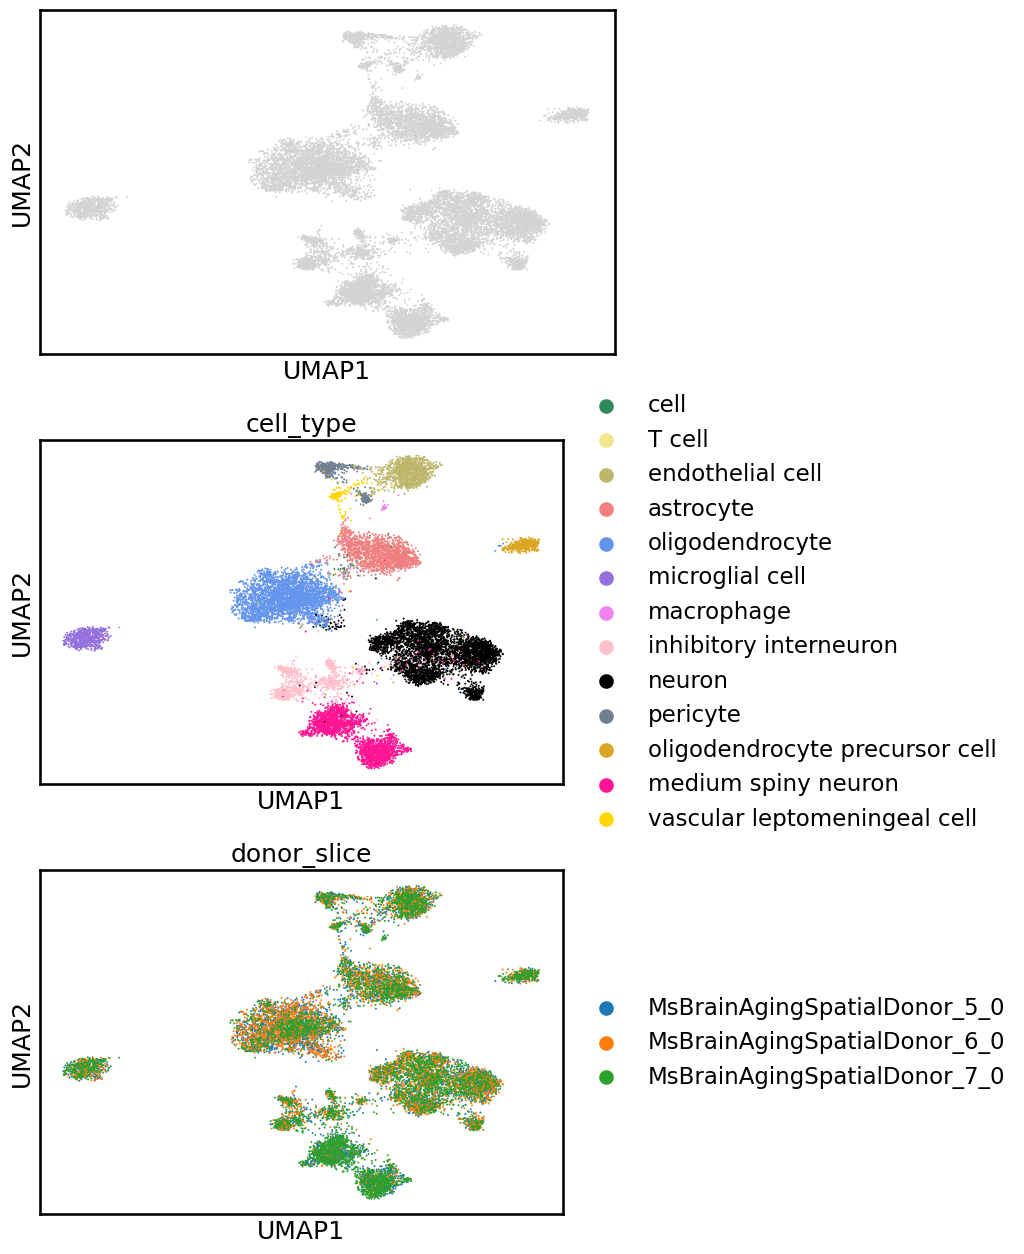

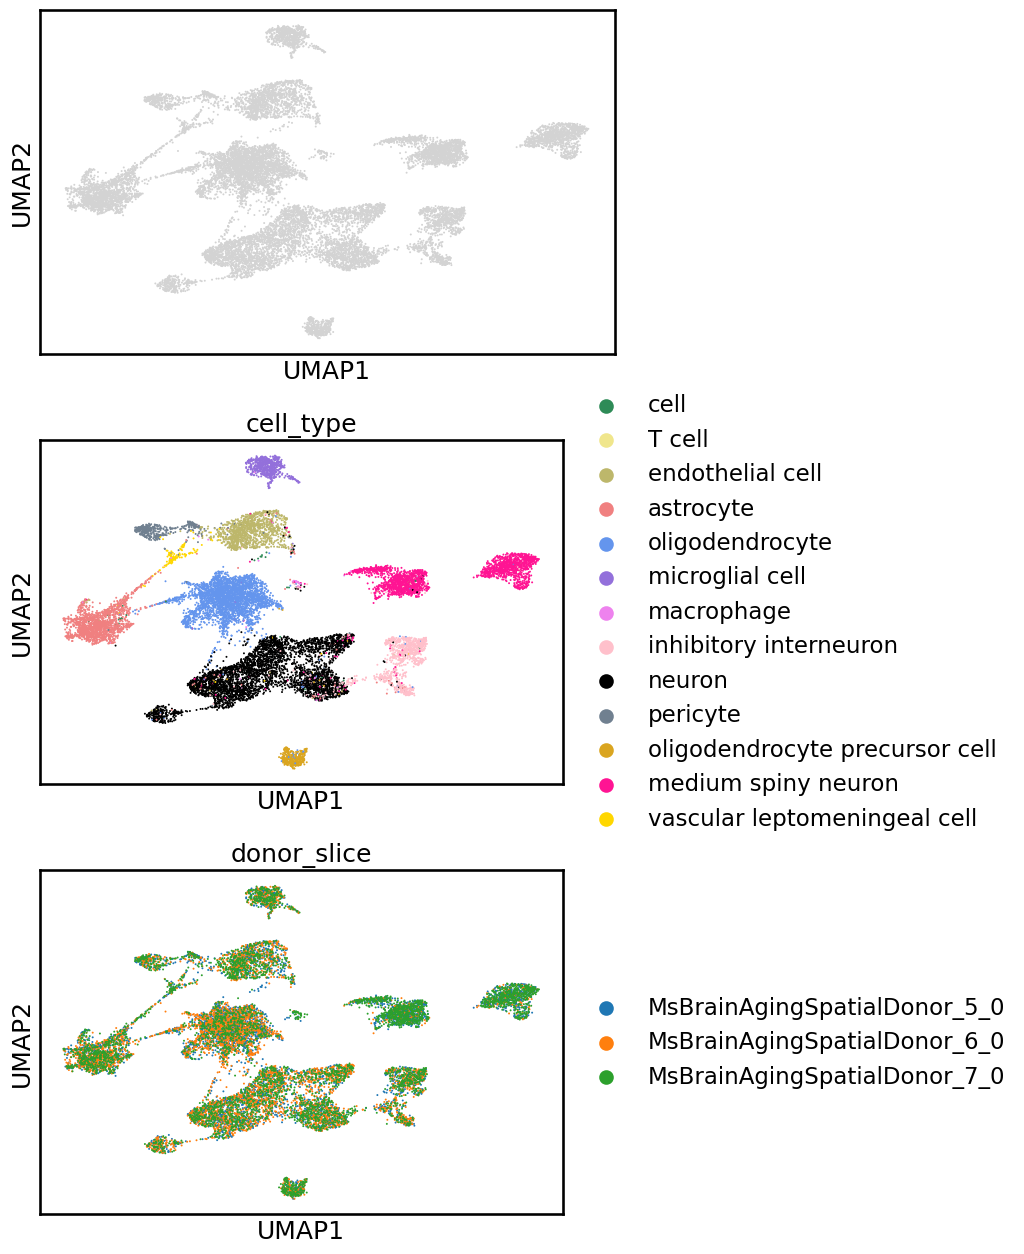

In [21]:
%matplotlib inline
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)
pass

## Scanorama

In [28]:
import scanorama

In [30]:
adatas = []
for i in chosen_slices:
    adatas.append(adata.raw.to_adata()[adata.obs['donor_slice'] == i, :])
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 374 genes among all datasets
[[0.     0.674  0.3928]
 [0.     0.     0.4738]
 [0.     0.     0.    ]]
Processing datasets (0, 1)
Processing datasets (1, 2)
Processing datasets (0, 2)


In [36]:
adata.obsm['X_scanorama'] = np.vstack([corrected[i].obsm['X_scanorama'] for i in range(3)])

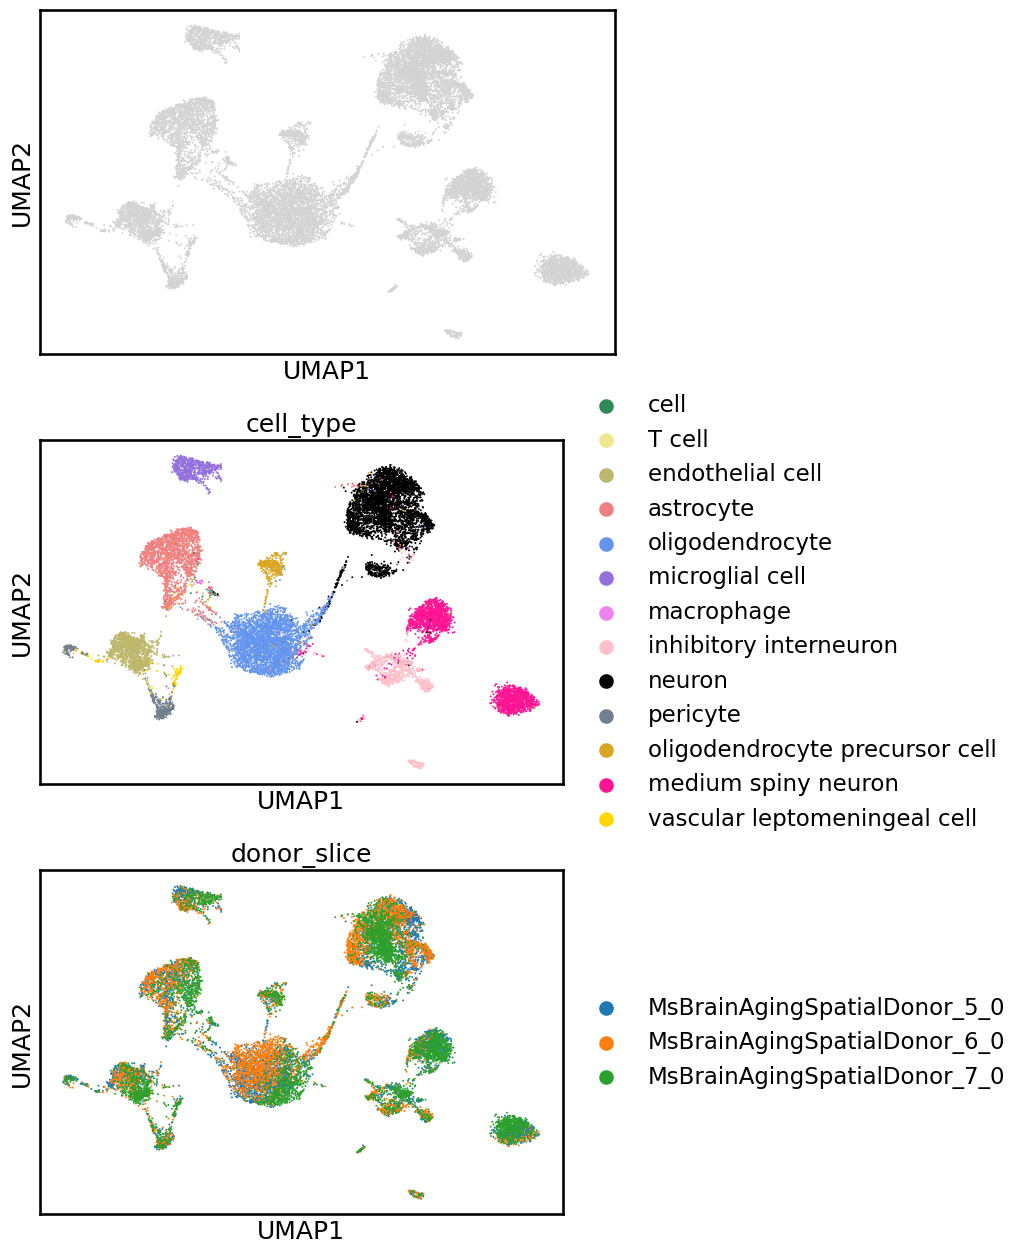

In [40]:
sc.pp.neighbors(adata, use_rep='X_scanorama', metric='cosine')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[None, 'cell_type', 'donor_slice'], ncols=1)

## Scoring and plotting 

In [39]:
adata.write("output/demo1-integration.h5ad")